In [1]:
!pip install meteostat

In [2]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Set time period
start = datetime(2000, 1, 1)
end = datetime(2022, 12, 31)

# Create Point for London
location = Point(51.5074, -0.1278)

# Get daily data for 2018
data = Daily(location, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
# data.plot(y=['tavg', 'tmin', 'tmax'])
# plt.show()

In [4]:
weather_data = data
weather_data.head(2)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2000-01-01,7.3,3.1,9.0,1.8,NaN,NaN,2.3,NaN,1024.5,NaN
2000-01-02,9.5,8.0,11.0,NaN,NaN,225.0,11.6,NaN,1025.2,NaN


In [5]:
# Descriptive statistics
weather_data.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,8401.000000,8308.000000,8336.000000,7432.000000,152.000000,7966.000000,8189.000000,1540.000000,7968.000000,0.0
mean,11.878086,8.781548,15.181706,1.869995,18.335526,198.013809,14.523373,32.904545,1015.240223,NaN
std,5.484631,5.098945,6.335085,3.833273,50.412464,94.619317,5.759111,10.815621,10.444610,NaN
min,-5.100000,-13.600000,-1.900000,0.000000,0.000000,0.000000,0.000000,13.000000,971.600000,NaN
25%,7.800000,5.000000,10.400000,0.000000,0.000000,124.000000,10.400000,25.900000,1009.000000,NaN
50%,11.800000,9.000000,15.000000,0.300000,10.000000,224.000000,13.800000,31.500000,1016.100000,NaN
75%,16.100000,12.900000,20.000000,1.800000,20.000000,263.000000,17.900000,38.900000,1022.200000,NaN
max,28.000000,22.300000,37.400000,48.000000,599.000000,359.000000,45.900000,98.200000,1047.300000,NaN


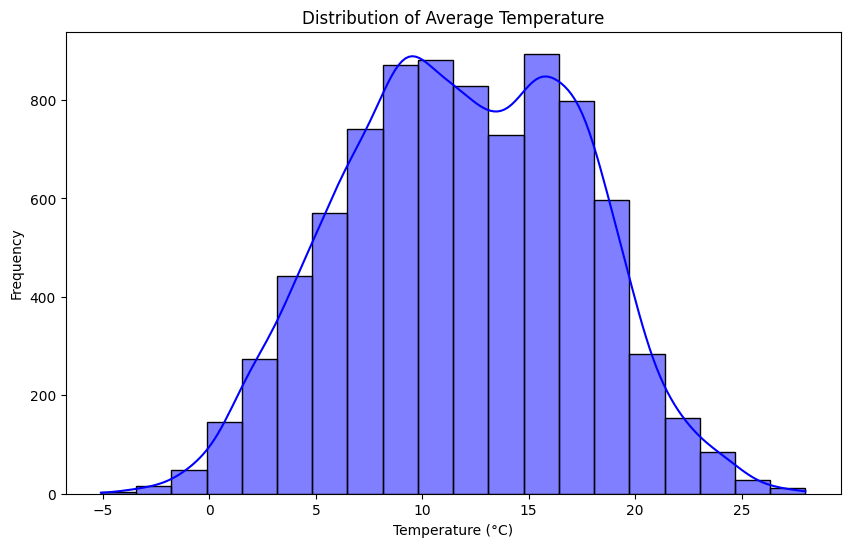

In [6]:
# Distribution of temperature
plt.figure(figsize=(10, 6))
sns.histplot(weather_data['tavg'], kde=True, bins=20, color='blue')
plt.title('Distribution of Average Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


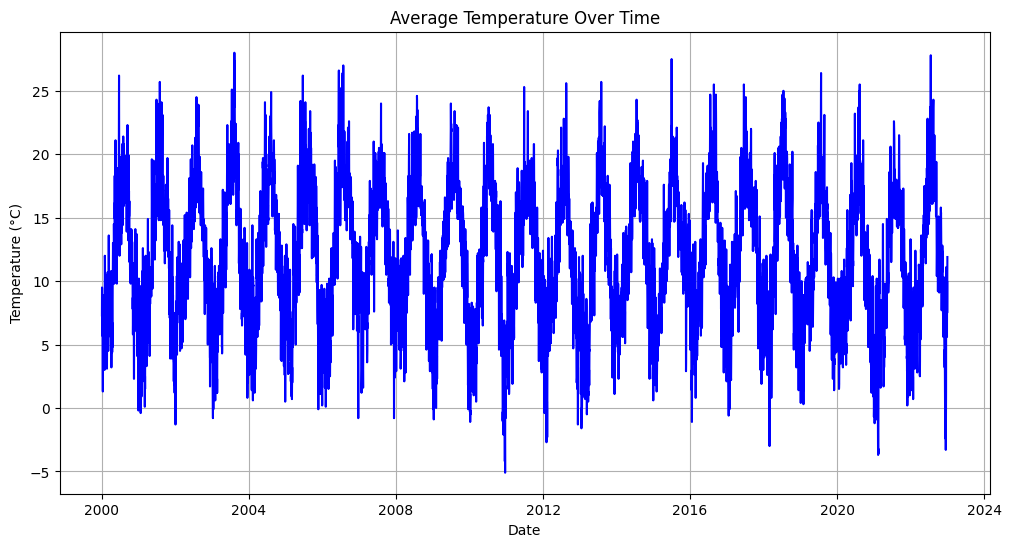

In [ ]:
# Time series analysis
plt.figure(figsize=(12, 6))
plt.plot(weather_data.index, weather_data['tavg'], color='blue')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


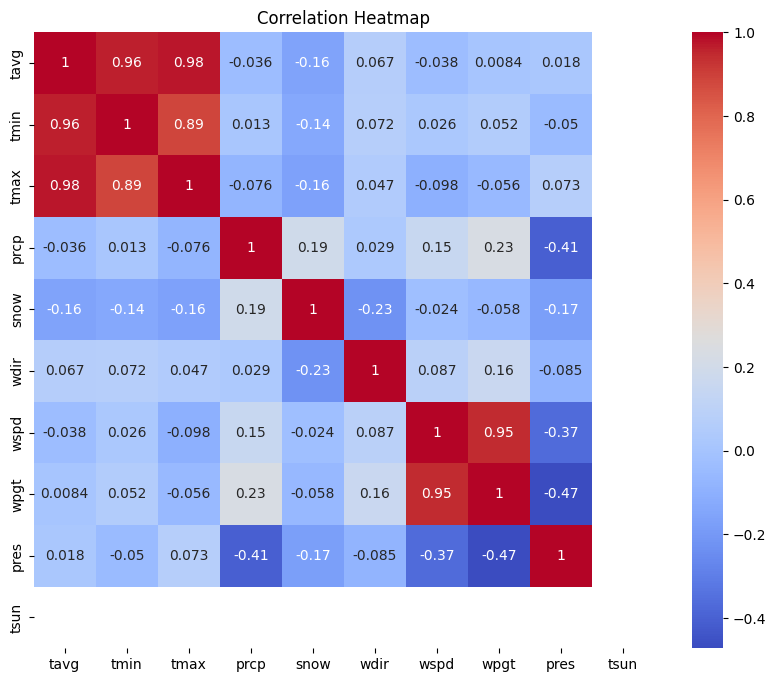

In [ ]:
# Correlation analysis
correlation_matrix = weather_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


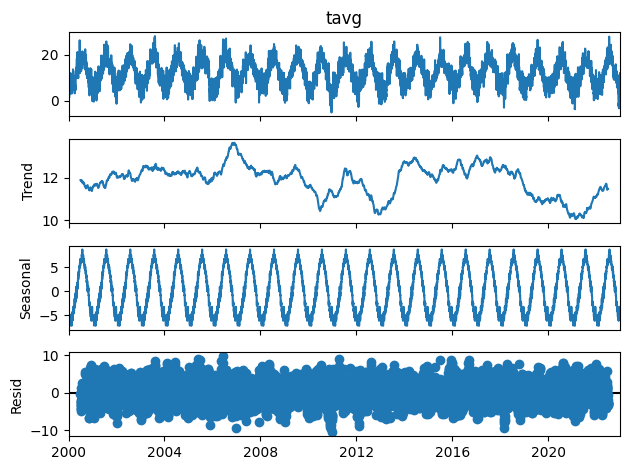

In [ ]:
# Seasonal decomposition
decomposition = seasonal_decompose(weather_data['tavg'], period=365)
decomposition.plot()
plt.show()

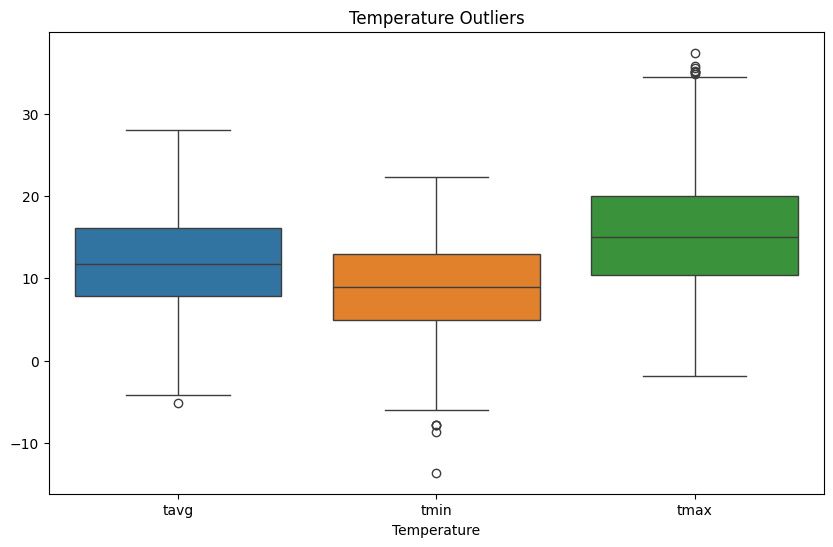

In [ ]:
# Outlier detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=weather_data[['tavg', 'tmin', 'tmax']])
plt.title('Temperature Outliers')
plt.xlabel('Temperature')
plt.show()

In [7]:
# Imputation of missing values
weather_data_filled = weather_data.fillna(weather_data.mean())

In [8]:
weather_data_filled.head(2)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2000-01-01,7.3,3.1,9.0,1.800000,18.335526,198.013809,2.3,32.904545,1024.5,NaN
2000-01-02,9.5,8.0,11.0,1.869995,18.335526,225.000000,11.6,32.904545,1025.2,NaN


In [9]:
weather_data_filled.drop('tsun', axis=1, inplace=True)

In [10]:
# Data preprocessing
temp_df = weather_data_filled[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(temp_df)


In [11]:
# Define window size for time series data
window_size = 30

# Function to create time series dataset
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create time series dataset
X, y = create_dataset(scaled_data, window_size)

In [12]:
# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
X_test[0].shape

(30, 9)

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(9)  # Output layer with 9 features
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/50
189/189 [==============================] - 20s 71ms/step - loss: 0.0222 - val_loss: 0.0142
Epoch 2/50
189/189 [==============================] - 8s 40ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 3/50
189/189 [==============================] - 6s 34ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 4/50
189/189 [==============================] - 7s 39ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 5/50
189/189 [==============================] - 7s 40ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/50
189/189 [==============================] - 7s 37ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 7/50
189/189 [==============================] - 8s 40ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 8/50
189/189 [==============================] - 6s 34ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 9/50
189/189 [==============================] - 8s 41ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 10/50
189/189 [==============================] - 7s 37ms/step - loss: 0.0096 - val_l

In [ ]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Forecasting
forecast = model.predict(X_test)

# Inverse transform forecasted values
forecast = scaler.inverse_transform(forecast)

53/53 [==============================] - 1s 14ms/step - loss: 0.0105
Test Loss: 0.010478375479578972
53/53 [==============================] - 2s 13ms/step


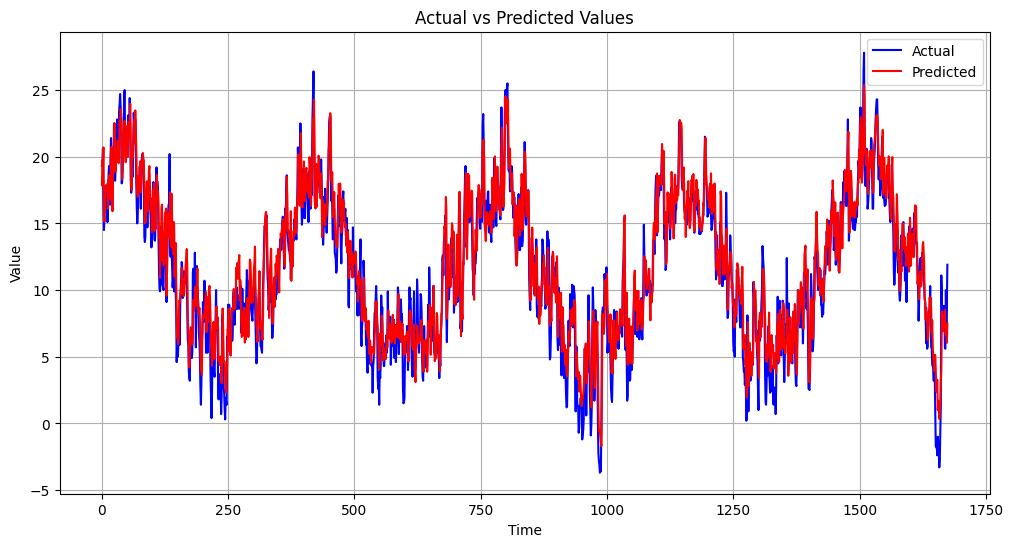

In [ ]:
import matplotlib.pyplot as plt

# Select a feature to plot (e.g., tavg)
feature_index = 0  # Index of tavg in the feature list

# Inverse transform actual values
actual_values = scaler.inverse_transform(y_test)
actual_values = actual_values[:, feature_index]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(forecast[:, feature_index], label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
temp_df.columns

Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres'], dtype='object')

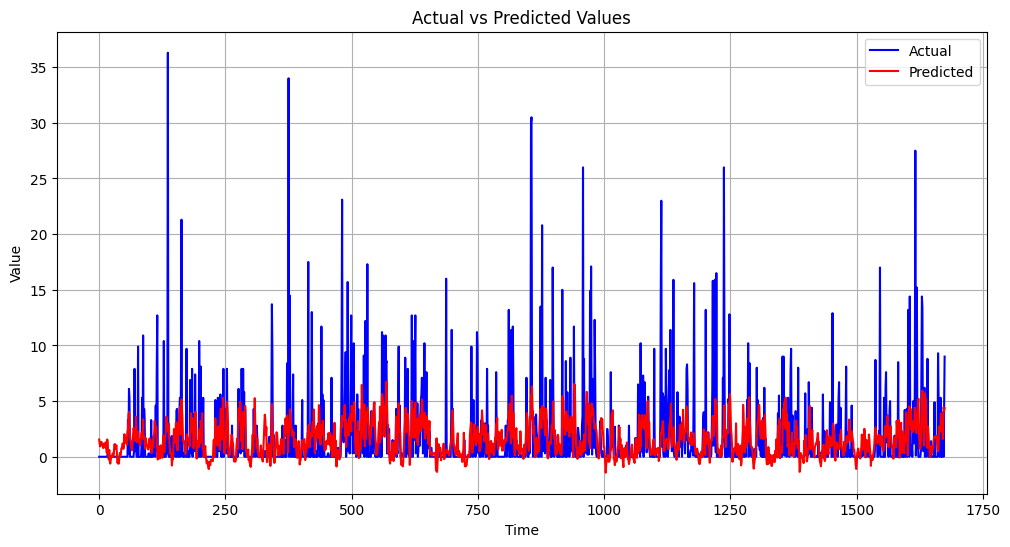

In [ ]:
import matplotlib.pyplot as plt

# Select a feature to plot (e.g., tavg)
feature_index = 3  # Index of tavg in the feature list

# Inverse transform actual values
actual_values = scaler.inverse_transform(y_test)
actual_values = actual_values[:, feature_index]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(forecast[:, feature_index], label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


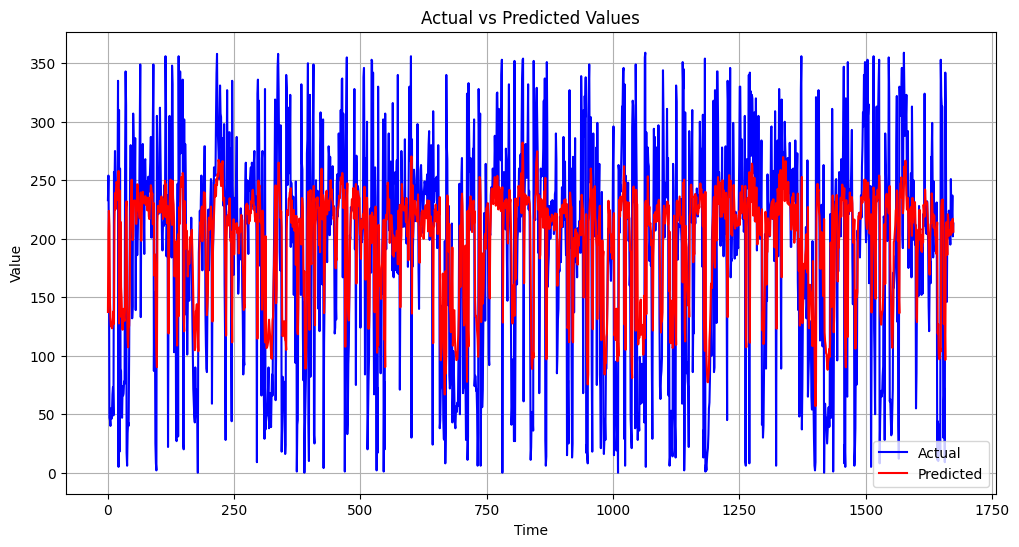

In [ ]:
import matplotlib.pyplot as plt

# Select a feature to plot (e.g., tavg)
feature_index = 5  # Index of tavg in the feature list

# Inverse transform actual values
actual_values = scaler.inverse_transform(y_test)
actual_values = actual_values[:, feature_index]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(forecast[:, feature_index], label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
